## Plot comparative log ratios across outcomes 
This code uses BIRDMAn output tables to compare log ratios across various outcomes. The example here uses the BIRDMAn results from the U19 Wisconsin study and compares the log ratios of microbes differentially abundant in patients with dementia, apoe4 carrier status, and amyloid positive pet scans.

In [88]:
#load packages
import pandas as pd
import numpy as np
import qiime2 as q2
import os
from filtering_significance import filter_significance

In [89]:
#replace with birdman_path
birdman_path = '/home/lakhatib/Wisconsin_MARS/metagenomics/birdman'

#replace with outcomes
outcomes = ['diagnosis', 'amyloid', 'apoe4']

#replace with output path
output_path = "/home/lakhatib/BIRDMAn_output_scripts/figures"

#import feature table and metadata
ft = q2.Artifact.load('/home/lakhatib/Wisconsin_MARS/metagenomics/data/feature_tables/prev_zebra_collapsed_l7_ft.qza').view(pd.DataFrame)
md = pd.read_csv('/home/lakhatib/Wisconsin_MARS/metagenomics/data/metadata/matched_metadata.tsv', sep='\t', index_col=0)

In [90]:
df = {}

for outcome in outcomes:
    #remove .nc files from inferences directory to clean/make space on server 
    if os.path.exists(f"{birdman_path}/{outcome}/inferences/birdman_feature-table"):
        !rm -r {birdman_path}/{outcome}/inferences/birdman_feature-table
    else:
        print(f"No {outcome} inferences directory found...")
    #load summarized inferences table
    df[outcome] = pd.read_csv(f"{birdman_path}/{outcome}/species/inferences-results/{outcome}_birdman_l7_ft.beta_var.tsv", sep="\t")

No diagnosis inferences directory found...
No amyloid inferences directory found...
No apoe4 inferences directory found...


In [91]:
top_negative = {}
top_positive = {}

for outcome in outcomes:
    if outcome == 'diagnosis':
        reverse_values = True
    else:
        reverse_values = False 
    
    df[outcome], top_positive[outcome], top_negative[outcome] = filter_significance(df[outcome], reverse_values=reverse_values, top_40=False)

Test column: diagnosis[T.Normal]
Total features before filtering: 651
Significant features: 252
Top Features: 95
Bottom Features: 157
Test column: amyloid[T.Positive]
Total features before filtering: 651
Significant features: 174
Top Features: 83
Bottom Features: 91
Test column: apoe4[T.Positive]
Total features before filtering: 651
Significant features: 254
Top Features: 80
Bottom Features: 174


In [92]:
#keep the lowest label
def extract_levels(split_features):
    features = []
    for feature in split_features:
        for level in reversed(feature):
            if level not in {'s__', 'g__', 'f__', 'o__', 'c__', 'p__'}:
                features.append(level)
                break
        else:
            features.append('N/A')  # If all levels are 's__', 'g__', etc.
    return features

split_features = ft.columns.str.split(';')
ft.columns = extract_levels(split_features)

In [93]:
#sum top and bottom feature abundance
for outcome in outcomes:
    #sum bottom features
    bottom_sum = ft[top_negative[outcome]['Feature']].sum(axis=1)
    #sum top features
    top_sum = ft[top_positive[outcome]['Feature']].sum(axis=1)
    
    #calculate log ratio of top/bottom features
    ft[f'log_ratios_{outcome}'] = np.log(top_sum/bottom_sum)

In [94]:
ft

,s__Lactococcus lactis,s__Escherichia coli,s__Fusobacterium nucleatum,s__Streptococcus mutans,s__Bifidobacterium longum,s__Enterococcus faecalis,s__Clostridioides difficile,s__Bacteroides fragilis,s__Limosilactobacillus fermentum,s__Bifidobacterium adolescentis,...,s__Solibaculum mannosilyticum,s__BX12 sp902363595,s__UMGS1375 sp900066615,s__CAG-45 sp000438375,s__Pseudobutyricicoccus sp003477405,s__Evtepia gabavorous,s__Ruminococcus_D sp000434695,log_ratios_diagnosis,log_ratios_amyloid,log_ratios_apoe4
13663.2137,2359.0,93772.0,2.0,30.0,175189.0,363.0,3493.0,22216.0,152.0,378.0,...,11198.0,3799.0,351708.0,26196.0,20326.0,56171.0,1514.0,-0.897464,-1.463335,-0.012406
13663.2138,57.0,604.0,0.0,0.0,11790.0,25.0,304.0,217809.0,4.0,71.0,...,797.0,225.0,3346.0,2345.0,1758.0,1875.0,52.0,0.560160,-0.979598,0.910205
13663.2139,4592.0,12785873.0,1.0,364.0,214924.0,1290.0,9459.0,38053.0,685.0,342966.0,...,12978.0,9316.0,91786.0,15904.0,4729.0,456511.0,122.0,1.948594,-1.448181,1.908308
13663.2140,0.0,2410.0,0.0,0.0,0.0,7.0,87.0,7043.0,0.0,0.0,...,1179.0,140.0,1029.0,592.0,289.0,177.0,3.0,1.289914,-0.812972,1.510009
13663.2141,202.0,735.0,2.0,0.0,29.0,38.0,720.0,47694.0,16.0,0.0,...,6106.0,975.0,10713.0,5812.0,1904.0,9079.0,869.0,-1.767467,-2.828797,-2.065657
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13663.mars00132,95.0,66.0,13.0,0.0,8552.0,20.0,91.0,550572.0,0.0,9839.0,...,498.0,113.0,894.0,238.0,349.0,5312.0,2.0,1.770504,-1.134280,0.665693
13663.mars00133,37.0,1354.0,0.0,0.0,917.0,6.0,229.0,33913.0,0.0,2.0,...,1283.0,236.0,1601.0,561.0,648.0,2503.0,39.0,-0.754332,-0.632692,-0.623007
13663.mars00134,19.0,6645.0,1.0,10.0,1.0,14.0,63.0,9560.0,0.0,0.0,...,267.0,126.0,1444.0,278.0,366.0,2279.0,0.0,3.351905,-0.136409,3.094846
13663.mars00135,4136.0,2366.0,0.0,23.0,45776.0,42.0,437.0,4901.0,38.0,2235.0,...,884.0,285.0,4088.0,4397.0,631.0,803.0,89.0,-0.592269,-1.620690,-1.053224


In [95]:
#add metadata columns to feature table
ft[outcomes] = md[outcomes]

In [96]:
#remove MCI
value= ['MCI-AD']
ft = ft[~ft['diagnosis'].isin(value)]

In [100]:
titles = ['Diagnosis', 'Amyloid', '$\mathit{APOE}$ $\mathit{ε4}$']

palette = [['lightblue', 'darkblue'], ['lightcoral', 'darkred'], ['lightgreen', 'darkgreen']]

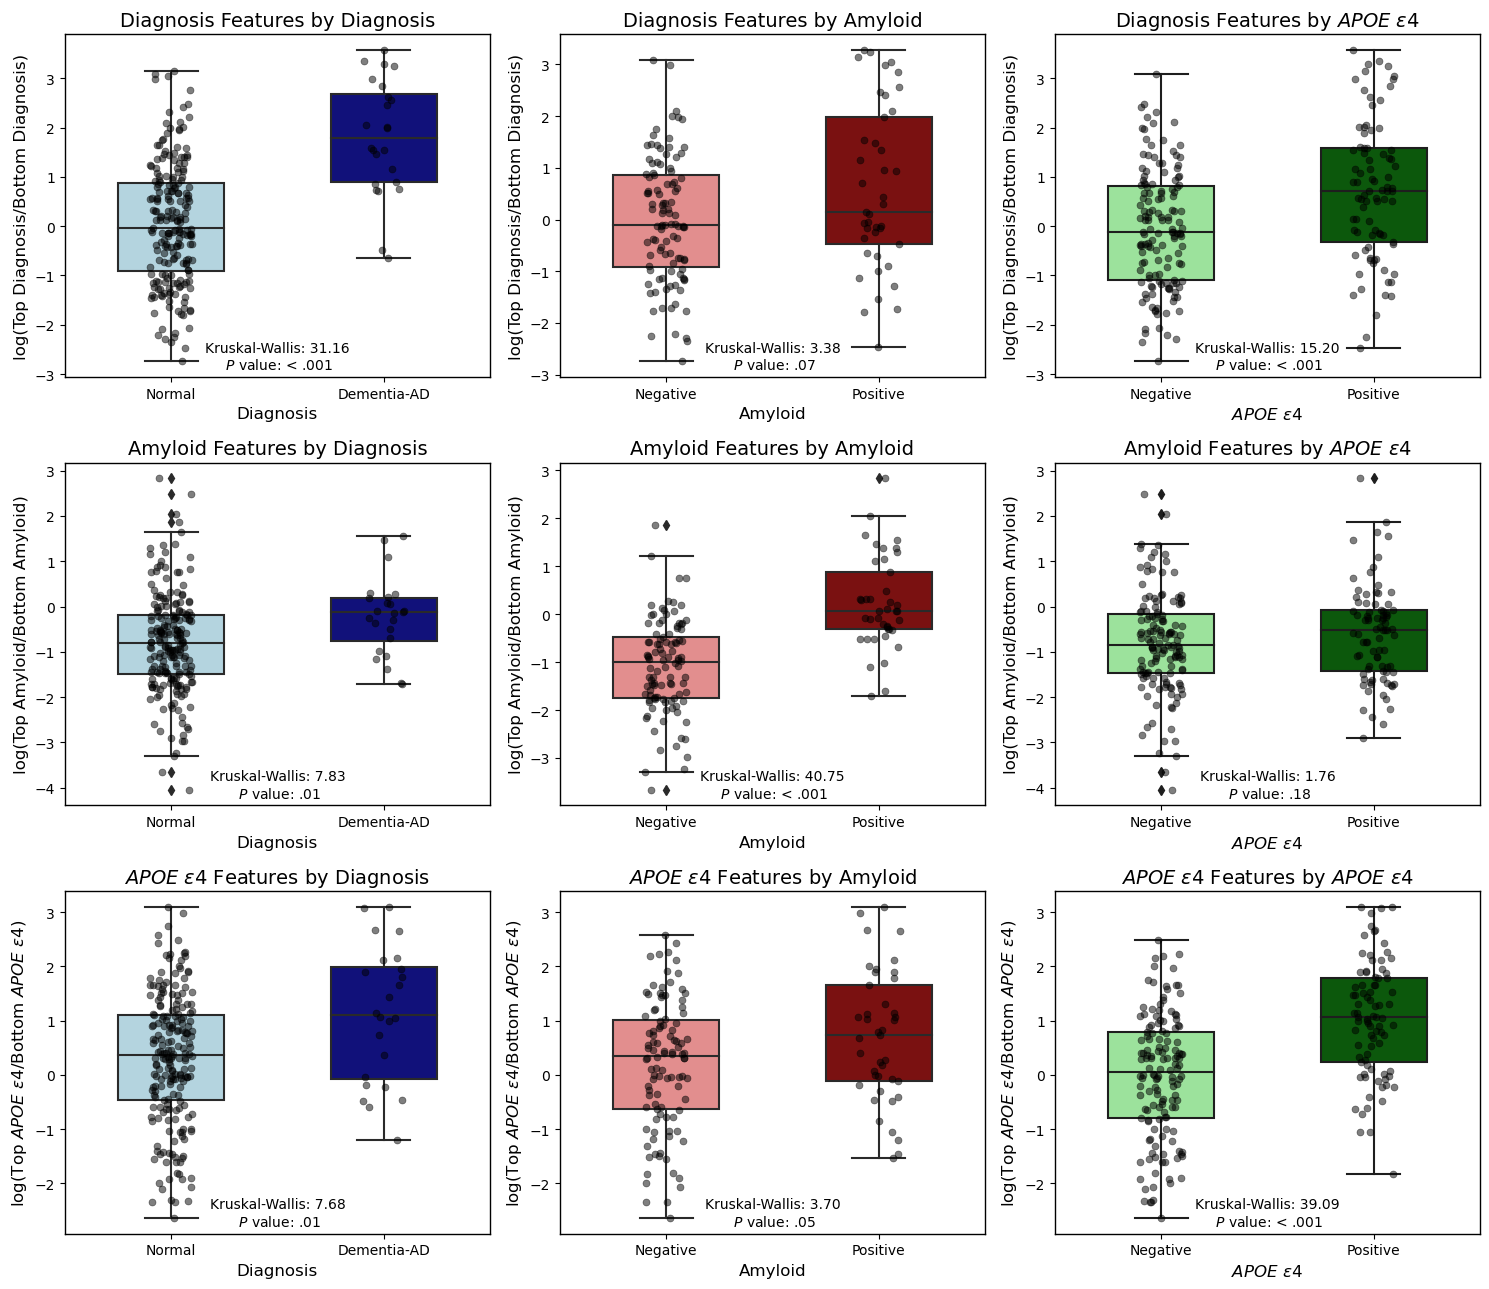

In [102]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import kruskal

# Set up the figure layout
fig, axes = plt.subplots(len(outcomes), len(outcomes), figsize=(15, 13))  # Adjust the figsize as needed

# Define common settings
jitter_value = 0.1  # Jitter for the stripplot
dot_size = 5  # Dot size for the stripplot

datasets = []

for outcome in outcomes:
    datasets.append(f'log_ratios_{outcome}')

for i, dataset in enumerate(datasets):
    for j, group in enumerate(outcomes):
        ax = axes[i][j]
        test_col = dataset
        group_col = group
        ft_test = ft.dropna(subset=group)
        group1_data = ft_test[ft_test[group_col] == ft_test[group_col].unique()[0]][test_col]
        group2_data = ft_test[ft_test[group_col] == ft_test[group_col].unique()[1]][test_col]

        # Perform the Kruskal-Wallis test
        statistic, pvalue = kruskal(group1_data, group2_data)

        # Boxplot
        sns.boxplot(x=group_col, y=test_col, data=ft_test, ax=ax, palette=palette[j], width=0.5)
        # Stripplot
        sns.stripplot(x=group_col, y=test_col, data=ft_test, ax=ax, color='k', size=dot_size, jitter=jitter_value, alpha=0.5, edgecolor='gray', linewidth=0.5)

        # Setting titles and texts
        if group_col == 'apoe4':
            group_title = '$\mathit{APOE}$ $\mathit{ε4}$'
        else:
            group_title = group_col.capitalize()
            
        ax.set_title(f'{titles[i]} Features by {group_title}', fontsize=14)
        p_value_text = f"< .001" if pvalue < 0.001 else f"{pvalue:.2f}".lstrip('0')
        ax.text(0.5, .06, f'Kruskal-Wallis: {statistic:.2f}\n $\mathit{{P}}$ value: {p_value_text}', ha='center', va='center', fontsize=10, transform=ax.transAxes)
        ax.set_xlabel(group_title, fontsize=12)
        ax.set_ylabel(f"log(Top {titles[i]}/Bottom {titles[i]})", fontsize=12)
        
            # Setting the linewidth and color of the axes spines
        for spine in ax.spines.values():
            spine.set_linewidth(1)  # Adjust this value to change the thickness of the border
            spine.set_edgecolor('black') 
            
# Tight layout to ensure no overlap
plt.tight_layout()
plt.savefig(f'{output_path}/log_ratios_outcomes.png', dpi=600)  # Adjust the path and DPI as necessary
plt.show()
